# Outlier Detection in Power Consumption Data via Forecast Error

### Authors: 
#### [Gustavo Felipe MARTIN NASCIMENTO](http://lattes.cnpq.br/7822903280012578) - [GRUCAD/EEL/UFSC](https://grucad.ufsc.br/) - [G2ELab/Grenoble-INP/UGA](https://g2elab.grenoble-inp.fr/)
####                 [Frédéric WURTZ](https://www.researchgate.net/profile/Frederic_Wurtz) - [G2ELab/Grenoble-INP/UGA](https://g2elab.grenoble-inp.fr/)
####                 [Benoît DELINCHANT](https://www.researchgate.net/profile/Benoit_Delinchant) - [G2ELab/Grenoble-INP/UGA](https://g2elab.grenoble-inp.fr/)
####                [Patrick KUO-PENG](http://lattes.cnpq.br/9920822116918042) - [GRUCAD/EEL/UFSC](https://grucad.ufsc.br/)
####                 [Nelson JHOE BATISTELA](http://lattes.cnpq.br/5387328100140459) - [GRUCAD/EEL/UFSC](https://grucad.ufsc.br/)
![title](images_outliers/logos.jpg)

#### This IPython Notebook presents the code used to detect outliers in the power consumption data from the GreEn-ER building. A tertiary building located in Grenoble - France.

##### Importing libraries

In [1]:
#Import python libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib notebook

##### Importing scripts

In [2]:
#Imports function to calculate the error metrics of the forecast results
from outdet.error_metrics import metrics_error

#Import function to plot the actual consumption and the forecast results
from outdet.plot_pred import plot_predict

#Import Function to calculate bounderies and number of outliers by each used method
from outdet.statistic_out_det import limites
from outdet.statistic_out_det import detection

#Import function to load and pre-process GreEn-ER global consumption data
from outdet.pre_processing import open_data

#Import function to plot data with 
from outdet.plot_error import plot_error_upper
from outdet.plot_error import plot_error_lower

# Pre-processing data

### This notebook explores the actual measurements


In [3]:
#Loading and pre-processing data
entry=str('Actual')
data,GT_out=open_data(entry,2017)
#data

In [5]:
#Plotting the Actual Consumption
fig, ax = plt.subplots()
#plt.plot(data.index,data['Actual'],'blue')
#ax2 = ax.twinx()
ax.plot(data.index,data['Actual'],'blue')
ax.set_ylim(0,1500)
#ax2.plot(GT_out.index,GT_out['Outliers'],'red')
#plt.plot(GT_out.index,GT_out['Outliers'],'red')
plt.legend(['Actual'])
plt.xlabel('Date')
#ax.ylabel('Energy consumption [kWh]')
#ax2.ylabel('Outlier')
ax.set_xlabel('Date')
#ax.set_ylabel('Energy consumption [kWh]')
#ax2.set_ylabel('Outlier')
plt.grid(True)

<IPython.core.display.Javascript object>

In [6]:
#Plotting the data distribution
plt.figure()
sns.distplot(data['Actual'])
plt.grid(True)
plt.ylabel('Probability')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Probability')

# Using Machine Learning to predict electricity consumption

In [7]:
#Set the trainning data

#gets rid of data with numerous outliers to train the model without these anomalies 
#data_train=data[:-240]
data_train=data

#Sets the train data features
X_tr=data_train.drop(['Actual'],axis=1)

#Sets the train data target
Y_tr=data_train['Actual']

#Sets Target Values of test data (measured consumption)
Y1=data['Actual']

#Sets Features the test data 
X1=data.drop(['Actual'],axis=1)

In [8]:
#Import train-test split function
from sklearn.model_selection import train_test_split
#Sets X and Y test as all avaiable data for 2017
y_test=Y1
X_test=X1

#Splits the train data
#Gets 50% of the samples in a randomly
X_train, X_testi, y_train, y_testi = train_test_split(
    X_tr, Y_tr, train_size=0.80, shuffle=False)

## Random Forest

#### Using the Random Forest method to obtain a model from the training dataset and forecasting the consumption for the test data

In [9]:
#Import Random Forest regressor
from sklearn.ensemble import RandomForestRegressor

#Choosing number of trees
n_esti=500
rf = RandomForestRegressor(n_estimators= n_esti)

#Train the model with fit function and trainning data
rf.fit(X_train, y_train);

#Predict consumption using fit model and features of test data
predictions_rf = rf.predict(X_test)

<IPython.core.display.Javascript object>


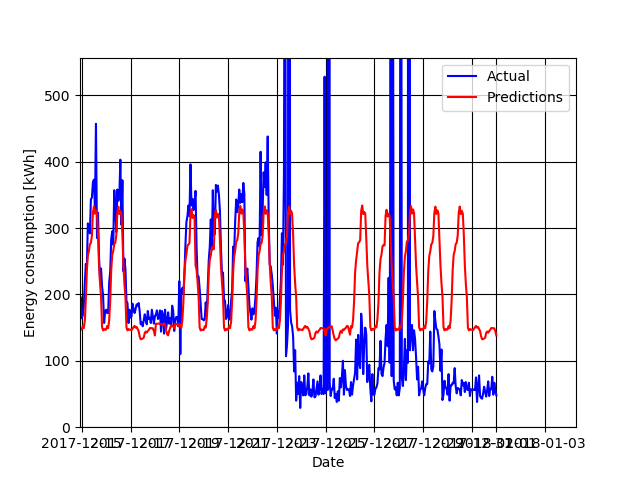

In [10]:
#plotting Random Forest predictions
plot_predict(X_test.index,y_test,predictions_rf)

In [11]:
#Calculates Random Forest Error Metrics
rf_err,rf_per=metrics_error(y_test,predictions_rf,'Random Forest')
rf_err

Random Forest
MAE       12.082119
MSE    34444.852219
RMSE     185.593244
MASE       0.408565
MAPE       0.068243

In [17]:
rff_resuts=y_test.to_frame()
rff_resuts['Predictions']=predictions_rf
mask = (rff_resuts.index >= '2017-10-20') & (rff_resuts.index <= '2017-12-22')
rff_resuts.loc[mask]

Actual  Predictions
Date                                    
2017-10-20 00:00:00   141.0      146.776
2017-10-20 01:00:00   152.0      140.066
2017-10-20 02:00:00   141.0      130.352
2017-10-20 03:00:00   155.0      141.936
2017-10-20 04:00:00   194.0      185.306
...                     ...          ...
2017-12-21 20:00:00   210.0      150.414
2017-12-21 21:00:00   184.0      145.916
2017-12-21 22:00:00   172.0      147.960
2017-12-21 23:00:00   162.0      146.922
2017-12-22 00:00:00   179.0      147.154

[1513 rows x 2 columns]

In [18]:
rf_err1,rf_per1=metrics_error(rff_resuts.loc[mask]['Actual'],rff_resuts.loc[mask]['Predictions'],'Random Forest')
rf_err1

Random Forest
MAE       19.631321
MSE      631.362656
RMSE      25.126931
MASE       1.067135
MAPE       0.089479

# Search For Outliers

## Using the following methods:

#### - 3-Sigma Rule
#### - BoxPlot
#### - Skewed BoxPlot
#### - Adjusted BoxPlot

##### The functions are described in the file "statistic_out_det.py"

In [19]:
#Looking for outliers directly with the measured data
from outdet.statistic_out_det import detection
global_out,oi,FL=limites(Y1)
res=detection(Y1,GT_out)
res

Potential Outliers Detected  True Positives  \
3 Sigma                                     6               6   
MAD                                       931              11   
BoxPlot                                     6               6   
Skewed BoxPlot                            152             151   
Adjusted BoxPlot                          271             172   

                  False Negatives  False Positives  Precision    Recall  \
3 Sigma                       206                0   1.000000  0.028302   
MAD                           201              920   0.011815  0.051887   
BoxPlot                       206                0   1.000000  0.028302   
Skewed BoxPlot                 61                1   0.993421  0.712264   
Adjusted BoxPlot               40               99   0.634686  0.811321   

                   F_Score  
3 Sigma           0.055046  
MAD               0.019248  
BoxPlot           0.055046  
Skewed BoxPlot    0.829670  
Adjusted BoxPlot  0.712215

In [20]:
plot_error_upper(global_out,data,data['Actual'])

<IPython.core.display.Javascript object>

In [21]:
plot_error_lower(global_out,data,data['Actual'])

<IPython.core.display.Javascript object>

## Outlier Detection via Forecast Error

##### The Forecast Error method compares the results of previous regression models with the measurements, resulting in an error. After, it applies the statistical methods for outlier detection on that error.
##### We used the three forecast methods and the four statistic outlier detection methods


### Random Forest

In [22]:
#Random Forest
FE_RF,value_RF,FL_RF=limites(rf_per['Error'])
res1=detection(rf_per['Error'],GT_out)
res1

Potential Outliers Detected  True Positives  \
3 Sigma                                     6               6   
MAD                                      1458             212   
BoxPlot                                   860             212   
Skewed BoxPlot                           1056             212   
Adjusted BoxPlot                          205             192   

                  False Negatives  False Positives  Precision    Recall  \
3 Sigma                       206                0   1.000000  0.028302   
MAD                             0             1246   0.145405  1.000000   
BoxPlot                         0              648   0.246512  1.000000   
Skewed BoxPlot                  0              844   0.200758  1.000000   
Adjusted BoxPlot               20               13   0.936585  0.905660   

                   F_Score  
3 Sigma           0.055046  
MAD               0.253892  
BoxPlot           0.395522  
Skewed BoxPlot    0.334385  
Adjusted BoxPlot  0.920863